# Adsorption in Zeolites with MoSDeF Cassandra

In this notebook we demonstrate how to use the [MoSDeF tools](https://mosdef.org) with the [Cassandra Monte Carlo software](https://cassandra.nd.edu) to simulate the adsorption of methane in a zeolite. The [MoSDeF Cassandra](https://mosdef-cassandra.readthedocs.io/en/latest/) package provides seamless integration between the MoSDeF tools and Cassandra. The [TraPPE-Zeo](https://pubs.acs.org/doi/10.1021/jp4074224) force field is used to model intermolecular interactions. Here we choose to use Grand Canonical Monte Carlo (GCMC), yielding a two step procedure. First, we perform GCMC simulations of pure methane at a range of chemical potential values in order to calculate the pressure of pure methane as a function of the chemical potential. Then we proceed to run GCMC of the methane and zeolite system, where the chemical potential of methane is chosen to yield some pressure of interest.

If you run all the simulations in this tutorial, it will take $\sim$20 minutes on a quad-core laptop and generate $\sim$500 MB of data.

# Setup
## Colab

In [ ]:
# Note: Run this cell first and by itself.
# The kernel will be restarted after this step
# There might be an error pops up stating the session crashed
# for an unknown reason, but that is expected.
!pip install -q condacolab
import condacolab
condacolab.install()

In [39]:
import condacolab
condacolab.check()

!conda install mamba

!mamba install anaconda-client -n base
!git clone https://github.com/MaginnGroup/CECAM-Workshop
!mamba env update -n base -f CECAM-Workshop/environment.yml
!pip install --upgrade ipykernel

%cd CECAM-MoSDeF-Workshop/slitpore_workflow

ModuleNotFoundError: No module named 'condacolab'

## Imports

The primary packages required are `mbuild`, `foyer`, and `mosdef_cassandra`. We use `numpy`,  `scipy`, and `matplotlib` for analysis. The `os` package `temporary_cd` function allow for directory creation. Known warnings are filtered to reduce verbosity in the example. We **do not** recommend filtering warnings in your work until you understand the meaning/implications of each.

In [1]:
import mbuild
import foyer
import mosdef_cassandra as mc
import unyt as u
import gmso

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd

# Filter some warnings -- to cleanup output for this demo
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)
from parmed.exceptions import OpenMMWarning
filterwarnings('ignore', category=OpenMMWarning)

/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/mdtraj/geometry/order.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/emarinri/miniconda3/envs/mosdef_conda/lib/python3.11/site-packages/pkg_resource

## Relating $\mu$ and $P$
Before we begin, we need to construct the mapping between the chemical potential of the adsorbate in the pure fluid phase, $\mu_\text{adsorbate}$ and pressure, $P$ at the temperature of interest. This requires performing a series of simulations of the pure fluid phase.

### Create a coarse-grained methane molecule, load and apply FF

We create a single site methane molecule in mBuild. We then load the force field from a foyer XML file and apply the force field to our methane molecule using GMSO. This yields `methane_typed`, stored as a `gmso.Topology` object. 

In [23]:
# Create an mbuild.Compound for UA methane.
methane = mbuild.Compound(name='_CH4')

ff_ads = foyer.Forcefield('methane.xml')
methane_typed = ff_ads.apply(methane)
methane_typed

<Structure 1 atoms; 1 residues; 0 bonds; PBC (orthogonal); parameterized>

### Select a temperature and run pure fluid phase simulations

Here we choose to run at 308 K. The `custom_args` dict is used to pass additional options to Cassandra. The TraPPE force field requires a cutoff of 14.0 Angstroms. Since the adsorbate molecule (methane) is neutral, we turn off long-range electrostatics by setting the `charge_style` to `"none"`.

The range of chemical potential values is selected as -46 kJ/mol to -25 kJ/mol in increments of 3 kJ/mol. We then use [MoSDeF Cassandra](https://mosdef-cassandra.readthedocs.io/en/latest/) to run the GCMC simulations.

Larger simulation boxes (20 x 20 x 20 nm$^3$) are used for the simulations at lower values of the chemical potential to ensure that the simulation box always has $>1$ methane molecule. At higher values of the chemical potential such large simulation boxes are not required and we use a smaller simulation box (5 x 5 x 5 nm$^3$) for efficiency.

This set of simulations takes $\sim$2 minutes on a quad-core laptop.

In [24]:
temperature = 308.0 * u.K

custom_args = {
    "charge_style" : "none",
    "vdw_cutoff" : 14.0 * u.angstrom,
    "prop_freq" : 10,
}

mus_adsorbate = np.arange(-46, -25, 3) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        species_list = [methane_typed]
        if mu_adsorbate < -34:
            boxl = 20. # nm
        else:
            boxl = 5. # nm
        box_list = [mbuild.Box([boxl,boxl,boxl])]
        system = mc.System(box_list, species_list)
        moveset = mc.MoveSet('gcmc', species_list)

        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            temperature=temperature,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )

Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Py

### Analyze the output

We calculate the average pressure and plot the pressure as a function of the MC step. Based on the plateau in the pressure values by $\sim$ step 20000, we conservatively start calculating the average pressure at step 30000.

Text(0, 0.5, 'Pressure (bar)')

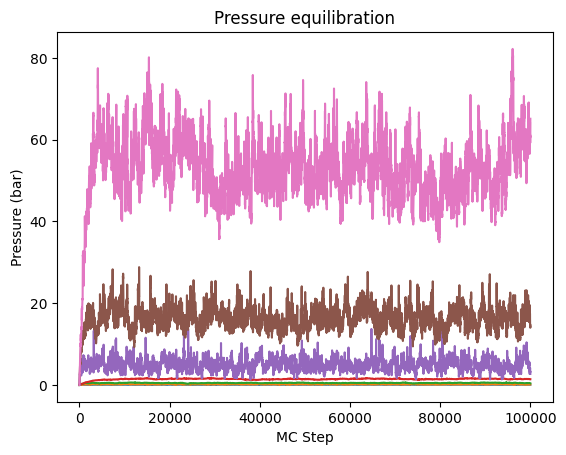

In [25]:
pressures = []
for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(dirname + "/gcmc.out.prp")
    pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure"))
plt.title("Pressure equilibration")
plt.xlabel("MC Step")
plt.ylabel("Pressure (bar)")

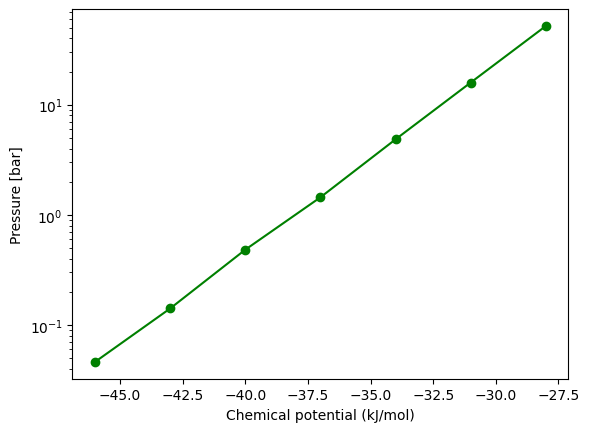

In [26]:
plt.plot(mus_adsorbate, pressures, 'go-')
plt.xlabel("Chemical potential (kJ/mol)")
plt.ylabel("Pressure [bar]")
plt.yscale('log')

### Fit $\mu$ vs. $\ln(P)$ 

In [27]:
slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())

### Calculate the required $\mu$ for a set of pressures.

 We can use our fit to calculate $\mu$ required to run at a series of pressures.

In [45]:
pressures = [
    6000   ,
    22100  ,
    49180  ,
    121800 ,
    316800 ,
    839700 ,
    # 2243000,
    # 6000000
] * u.Pa

mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
for (mu, pressure) in zip(mus, pressures):
    print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f}")

We will run at mu = -45.26 kJ/mol to simulate 6000 Pa
We will run at mu = -41.92 kJ/mol to simulate 22100 Pa
We will run at mu = -39.88 kJ/mol to simulate 49180 Pa
We will run at mu = -37.56 kJ/mol to simulate 121800 Pa
We will run at mu = -35.11 kJ/mol to simulate 316800 Pa
We will run at mu = -32.62 kJ/mol to simulate 839700 Pa


## Simulate adsorption in a zeolite

### Load a zeolite structure (MFI), load and apply FF

The porous material we will use is the MFI Silicalite zeolite. The atom location of the zeolitic framework can be defined in the Crystallographic Information File (CIF) format. The CIF file displayed below contains the relevant unit cell information for MFI Silicalite.

In [29]:
!cat MFI_SI.cif

data_MFI

_audit_creation_method RASPA-1.0
_audit_creation_date 2011-2-17
_audit_author_name 'David Dubbeldam'

_citation_author_name        'H. van Koningsveld, H. van Bekkum, and J. C. Jansen'
_citation_title              'On the location and disorder of the tetrapropylammonium (TPA) ion in zeolite ZSM-5 with improved framework accuracy'
_citation_journal_abbrev     'Acta Cryst.'
_citation_journal_volume     B43
_citation_page_first         127
_citation_page_last          132
_citation_year               1987

_cell_length_a    20.022
_cell_length_b    19.899
_cell_length_c    13.383
_cell_angle_alpha 90
_cell_angle_beta  90
_cell_angle_gamma 90
_cell_volume      5332.03

_symmetry_cell_setting          orthorhombic
_symmetry_space_group_name_Hall '-P 2ac 2n'
_symmetry_space_group_name_H-M  'P n m a'
_symmetry_Int_Tables_number     62

loop_
_symmetry_equiv_pos_as_xyz
 'x,y,z'
 '-x+1/2,-y,z+1/2'
 '-x,y+1/2,-z'
 'x+1/2,-y+1/2,-z+1/2'
 '-x,-y,-z'
 'x+1/2,y,-z+1/2'
 'x,-y+1/2,z'
 '-x+1

The `mbuild` package provides functionality to generate `mb.Compound` objects from CIF files. Additionally, we can construct supercells very easily using the `mb.Compound.populate` method. In the case at hand, we create a 2x2x3 supercell of the zeolite.

In [46]:
# This is the CIF for MFI framework
lattice = mbuild.lattice.load_cif("MFI_SI.cif")
print(lattice)
# Construct a map of elements in the CIF
# to mbuild compounds
compound_dict = {
    "Si4+": mbuild.Compound(name="Si"),
    "O2-": mbuild.Compound(name="O"),
}

# Create the supercell
mfi = lattice.populate(compound_dict, 2, 2, 3)
mfi.translate(-mfi.center)
mfi.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [47]:
ff_zeo = foyer.Forcefield('trappe-zeo.xml')
zeolite_typed = ff_zeo.apply(mfi)
zeolite_typed

<Structure 3456 atoms; 1 residues; 0 bonds; PBC (orthogonal); parameterized>

### Setup a GCMC system with MoSDeF Cassandra

GCMC requires a single simulation box which contains the MFI zeolite. Thus, we use the `mbuild.Compound` zeolite as our initial box. The two species in the simulation are the MFI and our CG methane.

Our initial structure contains 1 zeolite and no methane. Since GCMC can insert molecules we do not need to add any methane to our starting structure.

In [48]:
box_list = [mfi]
species_list = [zeolite_typed, methane_typed]

mols_in_boxes = [[1,0]]

We can now create the `mc.System` and `mc.MoveSet` objects.

In [49]:
system = mc.System(
    box_list,
    species_list,
    mols_in_boxes=mols_in_boxes,
)

moveset = mc.MoveSet('gcmc', species_list)

Treating <Structure 3456 atoms; 1 residues; 0 bonds; PBC (orthogonal); parameterized> as a non-insertable rigid species since it has no bonds


### We can view the selected move probabilities

In [35]:
moveset.print()


Ensemble:  gcmc

Probability of selecting each move type:

    Translate: 0.8
    Rotate:    0.0
    Regrow:    0.0
    Volume:    0.0
    Insert:    0.1
    Delete:    0.1
    Swap:      0.0
    Angle:     0.0
    Dihedral:  0.0

CBMC selections:

    Number of trial positions: 10
    Number of trial dihedral angles: 10
    CBMC cutoff(s): 
        Box 1: 6.0 Å


Per species quantities:

                             species1     species2     
                             ========     ========     
    Max translate (Ang):     0.00 Å          2.00 Å          (Box 1)
    Max rotate (deg):        0.00 degree         0.00 degree         (Box 1)
    Insertable:              False          True          
    Max dihedral:            0.00 degree          0.00 degree          
    Prob swap:               0.00          0.00          
    Prob regrow:             0.00          0.00          


Max volume (Ang^3):
    Box 1: 0.0 Å**3



## Run simulations

The following set of simulations requires $\sim$15 minutes on a quad-core laptop. That can be reduced to $\sim$5 minutes by removing the three highest pressures.

In [50]:
custom_args = {
    "charge_style" : "none",
    "vdw_cutoff" : 14.0 * u.angstrom,
    "prop_freq" : 10,
    "coord_freq" : 500,
}

for (pressure, mu) in zip(pressures, mus):
    
    dirname = f"zeo_press_{pressure.value:0.0f}"
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            temperature=temperature,
            chemical_potentials = ["none", mu],
            **custom_args
        )

Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /home/emarinri/miniconda3/envs/mosdef_conda/bin/python
library_setup: /home/emarinri/miniconda3/envs/mosdef_conda/bin/library_setup.py
Cassandra: /home/emarinri/miniconda3/envs/mosdef_conda/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Py

## Extract the results and plot

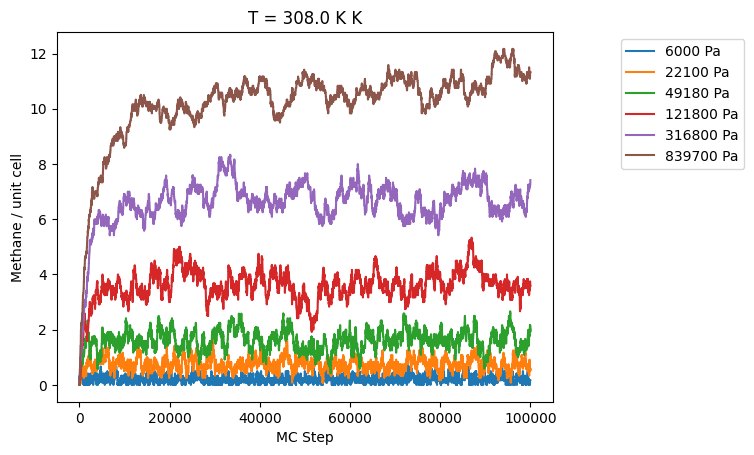

In [51]:
loading = []
for pressure in pressures:
    dirname = f"zeo_press_{pressure.value:0.0f}"
    thermo = ThermoProps(f"{dirname}/gcmc.out.prp")
    n_unitcells = 12
    loading.append(np.mean(thermo.prop("Nmols_2", start=30000)/n_unitcells))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Nmols_2")/n_unitcells, label=f"{pressure:0.0f}")
    
plt.title(f"T = {temperature:0.1f} K")
plt.xlabel('MC Step')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', ncol=1)
plt.ylabel('Methane / unit cell')
plt.show()

## Comparison with literature

We can also compare our results with existing results from the [literature](https://pubs.acs.org/doi/10.1021/jp4074224). Not bad for a relatively short simulation! 

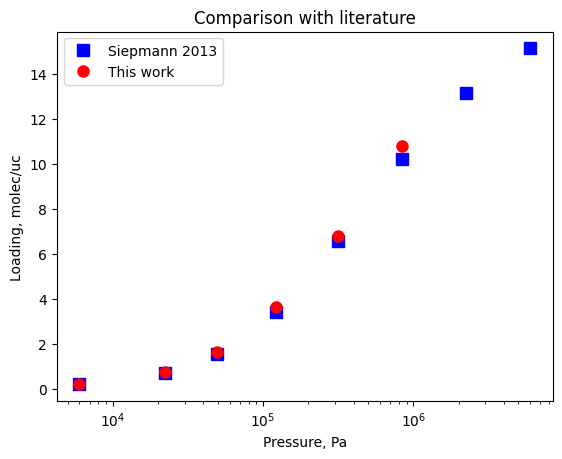

In [88]:
published_results = np.genfromtxt('lit_results.dat', skip_header=3)
plt.plot(published_results[:,0], published_results[:,1], 'bs', markersize=8, label="Siepmann 2013")
plt.plot(pressures, loading, 'ro', markersize=8, label="This work")
plt.title("Comparison with literature")
plt.xlabel("Pressure, Pa")
plt.ylabel("Loading, molec/uc")
plt.legend()
plt.xscale("log")

In [92]:
# Visualization of the final frame
lines = !grep -n MC_STEP zeo_press_316800/gcmc.out.xyz | tail -n 1 | awk -F':' '{{print $$1}}'
total= !cat zeo_press_316800/gcmc.out.xyz|wc -l
last = int(total[0])-int(lines[0]) + 2
!tail -n $last zeo_press_316800/gcmc.out.xyz > viz.xyz
system = mbuild.load("viz.xyz")
system.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Summary

In this notebook we showed how the MoSDeF tools can be used with Cassandra to run a series of Grand Canonical Monte Carlo simulations and model the adsorption of methane in a zeolite.